In [1]:
import pandas as pd
import numpy as np
import os
import glob
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd
import wfdb
import statsmodels.api as sm
import matplotlib.image as mpimg
import tkinter as tk
from matplotlib.figure import Figure
from IPython.display import display, HTML
import csv
from collections import defaultdict
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
import pickle
from sklearn.linear_model import LogisticRegression
import tensorflow.keras as ks
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as Ks
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from numpy.random import seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
train_data=pd.read_csv('TrainingSeg.csv',header=0)

In [3]:
display(train_data.head(5))

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,19.0,15.4,16.6,14.5,15.8,15.9,16.5,15.0,15.6,17.8,...,19.3,17.70,18.40,18.60,20.40,19.6,18.9,18.6,17.8,19.2
1,96.0,96.1,96.8,97.0,97.0,97.0,97.0,97.9,98.0,97.8,...,98.6,98.52,98.44,98.36,98.28,98.2,97.8,99.0,98.2,98.4
2,106.3,103.8,104.4,103.4,103.5,102.7,102.2,101.8,101.1,101.4,...,76.2,75.20,76.10,77.90,71.60,74.5,72.4,70.6,75.0,76.5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
4,10.0,10.0,10.0,10.0,10.0,10.0,10.5,10.2,10.6,10.0,...,10.0,10.60,11.00,11.00,10.00,10.0,10.1,11.0,12.4,17.1


# Importing the Normalization Parameters 

In [4]:
normalize_param=pd.read_csv('parStat.csv',header=0)
display(normalize_param)
display(normalize_param.iloc[0,1])
mean_rr,std_rr=normalize_param.iloc[0,1],normalize_param.iloc[0,2]
mean_spo2,std_spo2=normalize_param.iloc[1,1],normalize_param.iloc[1,2]
mean_hr,std_hr=normalize_param.iloc[2,1],normalize_param.iloc[2,2]

,Parameter,Mean,StdDev
0,RR,20.073284,6.376141
1,SpO2,96.074189,4.515870
2,HR,86.446392,18.010956


20.07328408143529

# Function to normalize the given dataframe using respective mean,std

In [5]:
def normalize_data(df):
    row_index=df.index
    for i in range(len(row_index)):
        #display(i)
        if i%4==0:
            #print(df.iloc[i,:])
            df.iloc[i,:]=df.iloc[i,:].apply(lambda x:(x-mean_rr)/std_rr)
            #print(df.iloc[i,:])
        elif i%4==1:
            df.iloc[i,:]=df.iloc[i,:].apply(lambda x:(x-mean_spo2)/std_spo2)
        elif i%4==2:
            df.iloc[i,:]=df.iloc[i,:].apply(lambda x:(x-mean_hr)/std_hr)
    return df


In [6]:
# normalizing train data
train_data=normalize_data(train_data)
display(train_data.head(5))

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.168328,-0.732933,-0.544731,-0.874084,-0.670199,-0.654516,-0.560415,-0.795667,-0.701566,-0.356530,...,-0.121278,-0.372213,-0.262429,-0.231062,0.051240,-0.074227,-0.184012,-0.231062,-0.356530,-0.136961
1,-0.016428,0.005716,0.160725,0.205013,0.205013,0.205013,0.205013,0.404310,0.426454,0.382166,...,0.559319,0.541604,0.523888,0.506173,0.488458,0.470742,0.382166,0.647895,0.470742,0.515031
2,1.102307,0.963503,0.996816,0.941294,0.946846,0.902429,0.874668,0.852459,0.813594,0.830251,...,-0.568898,-0.624419,-0.574450,-0.474511,-0.824298,-0.663285,-0.779880,-0.879820,-0.635524,-0.552241
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-1.579840,-1.579840,-1.579840,-1.579840,-1.579840,-1.579840,-1.501423,-1.548473,-1.485740,-1.579840,...,-1.579840,-1.485740,-1.423006,-1.423006,-1.579840,-1.579840,-1.564157,-1.423006,-1.203437,-0.466314


In [7]:
# reading and normalizing validation data

validation_data=pd.read_csv('ValidationSeg.csv',header=0)
validation_data=normalize_data(validation_data)
display(validation_data.head(5))

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,2.341003,2.341003,2.341003,0.587115,0.080020,0.678585,1.295477,0.668113,0.362286,0.268197,...,-0.508153,-1.057056,-1.080538,-1.143291,-1.070146,-1.119808,-1.219133,-1.266177,-1.347176,-1.313221
1,-0.680721,-0.680721,-0.621674,-0.529434,-0.422367,-0.459305,-0.654918,-0.765626,-1.041604,-0.741405,...,-0.079162,-0.090243,-0.060693,-0.105018,-0.079162,-0.082856,-0.020114,-0.038583,-0.056999,-0.045918
2,-1.131830,-1.131830,-1.131830,-1.131830,-1.268488,-1.286048,-1.028819,-0.907611,-0.910318,-1.016794,...,-0.531881,-0.544862,-0.705849,-0.741964,-0.753074,-0.754906,-0.779872,-0.799303,-0.791937,-0.836335
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-1.078000,-1.109336,-1.130280,-1.106718,-1.125044,-0.879271,0.349196,0.065105,-0.157899,-0.450637,...,-1.064910,-0.743374,-1.096246,-1.122426,-1.158998,-1.195571,-1.098864,-1.185099,-1.177324,-1.151145


In [8]:
# reading and normalizing test data

test_data=pd.read_csv('TestSeg.csv',header=0)
test_data=normalize_data(test_data)
display(test_data.head(5))

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-1.169500,-1.169500,-0.011547,-1.632089,1.578194,0.834262,0.438011,0.223794,-0.748372,-0.615302,...,-0.432280,0.025175,-0.288548,-0.638796,-0.625766,-0.680652,0.362393,-0.487167,-0.644127,-0.461105
1,0.623251,0.607319,0.588796,0.607707,0.626618,0.526105,0.566777,0.537244,0.666383,0.670010,...,0.869223,0.869223,0.869223,0.869223,0.869223,0.869223,0.869223,0.869223,0.869223,0.869223
2,-1.087672,-0.962126,-1.037255,-1.024189,-1.019929,-0.562481,-0.493034,-0.398448,-0.759464,-0.743841,...,-0.014567,0.030737,-0.042403,-0.229302,-0.226462,-0.304289,0.205564,-0.091400,-0.280145,-0.246912
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.785293,-0.795757,-0.795757,-0.795757,-0.795757,-0.795757,-0.795757,-0.795757,-0.795757,-0.795757,...,0.179372,0.391021,0.289145,-0.173641,-0.398321,-0.228528,-0.168310,-0.074134,-0.113423,0.116588


### Function to convert the given data to required 3D input

In [9]:
def convert_to_3darray(df):
    df=df.T
    columns=df.columns
    segments=[]
    for i in range(0,len(columns),4):
        col_subset=columns[i:i+4]
        segments.append(df[col_subset].values)
    display(segments[0]) 
    #display(type(segments[0]))
    #display(type(segments))
    return np.asarray(segments)


In [10]:
# converting train data to 3D Array
train_data_final=convert_to_3darray(train_data)
display(train_data_final.shape)


array([[-0.16832817, -0.01642845,  1.10230725,  0.        ],
       [-0.73293303,  0.00571568,  0.96350285,  0.        ],
       [-0.54473141,  0.16072456,  0.99681591,  0.        ],
       ...,
       [-0.23106204,  0.64789532, -0.87981957,  0.        ],
       [-0.35652979,  0.47074232, -0.63552383,  0.        ],
       [-0.13696123,  0.51503057, -0.55224119,  0.        ]])

(1707, 1024, 4)

In [11]:
# converting validation data to 3D Array
val_data_final=convert_to_3darray(validation_data)
display(val_data_final.shape)

array([[ 2.34100261, -0.68072132, -1.13182999,  0.        ],
       [ 2.34100261, -0.68072132, -1.13182999,  0.        ],
       [ 2.34100261, -0.62167352, -1.13182999,  0.        ],
       ...,
       [-1.26617697, -0.0385831 , -0.79930349,  0.        ],
       [-1.34717568, -0.05699926, -0.79193702,  0.        ],
       [-1.31322128, -0.0459179 , -0.83633494,  0.        ]])

(446, 1024, 4)

In [12]:
# converting test data to 3D Array
test_data_final=convert_to_3darray(test_data)
display(test_data_final.shape)

array([[-1.16949991,  0.62325059, -1.08767235,  0.        ],
       [-1.16949991,  0.60731871, -0.96212645,  0.        ],
       [-0.01154733,  0.58879629, -1.03725516,  0.        ],
       ...,
       [-0.48716673,  0.86922321, -0.09140025,  0.        ],
       [-0.64412705,  0.86922321, -0.28014517,  0.        ],
       [-0.46110539,  0.86922321, -0.24691243,  0.        ]])

(659, 1024, 4)

##  spillting data into features and labels

In [13]:

def split_features_label(arr):
    x=arr[:,:,:3]
    y=arr[:,:,3:]
    display(x.shape)
    display(y.shape)
    return x,y

In [14]:
# splitting train,test and validation data into features and labels
x_train,y_train=split_features_label(train_data_final)
x_val,y_val=split_features_label(val_data_final)
x_test,y_test=split_features_label(test_data_final)

(1707, 1024, 3)

(1707, 1024, 1)

(446, 1024, 3)

(446, 1024, 1)

(659, 1024, 3)

(659, 1024, 1)

## LSTM Model definition

In [15]:
# design network
seed(7)
model = Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
print(model.summary())
# fit network
EPOCHS = 100
BATCH_SIZE = 1707
model_checkpoint = ModelCheckpoint('SegLSTM.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
csv_logger = CSVLogger('SegLSTM.log')
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1, shuffle=False,callbacks=[csv_logger,model_checkpoint])
print('Score on validation set')
score = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print(score)
print('Score on test set')
score = model.evaluate(x_test,y_test, batch_size=BATCH_SIZE)
print(score)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1024, 100)         41600     
_________________________________________________________________
dense (Dense)                (None, 1024, 1)           101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________
None
Train on 1707 samples, validate on 446 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.12363, saving model to SegLSTM.h5
1707/1707 [==============================] - 3s 2ms/sample - loss: 0.2625 - val_loss: 0.1236
Epoch 2/100

Epoch 00002: val_loss improved from 0.12363 to 0.12280, saving model to SegLSTM.h5
1707/1707 [==============================] - 0s 288us/sample - loss: 0.2140 - val_loss: 0.1228
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.12280
1707/1707 [===========

Epoch 45/100

Epoch 00045: val_loss did not improve from 0.07977
1707/1707 [==============================] - 0s 279us/sample - loss: 0.0696 - val_loss: 0.0815
Epoch 46/100

Epoch 00046: val_loss did not improve from 0.07977
1707/1707 [==============================] - 0s 284us/sample - loss: 0.0692 - val_loss: 0.0806
Epoch 47/100

Epoch 00047: val_loss did not improve from 0.07977
1707/1707 [==============================] - 0s 284us/sample - loss: 0.0687 - val_loss: 0.0805
Epoch 48/100

Epoch 00048: val_loss did not improve from 0.07977
1707/1707 [==============================] - 0s 289us/sample - loss: 0.0683 - val_loss: 0.0801
Epoch 49/100

Epoch 00049: val_loss improved from 0.07977 to 0.07905, saving model to SegLSTM.h5
1707/1707 [==============================] - 0s 292us/sample - loss: 0.0680 - val_loss: 0.0790
Epoch 50/100

Epoch 00050: val_loss improved from 0.07905 to 0.07897, saving model to SegLSTM.h5
1707/1707 [==============================] - 0s 291us/sample - loss: 0.


Epoch 00095: val_loss did not improve from 0.07187
1707/1707 [==============================] - 0s 274us/sample - loss: 0.0645 - val_loss: 0.0777
Epoch 96/100

Epoch 00096: val_loss did not improve from 0.07187
1707/1707 [==============================] - 0s 271us/sample - loss: 0.0647 - val_loss: 0.0767
Epoch 97/100

Epoch 00097: val_loss improved from 0.07187 to 0.07068, saving model to SegLSTM.h5
1707/1707 [==============================] - 0s 278us/sample - loss: 0.0644 - val_loss: 0.0707
Epoch 98/100

Epoch 00098: val_loss did not improve from 0.07068
1707/1707 [==============================] - 0s 270us/sample - loss: 0.0661 - val_loss: 0.0727
Epoch 99/100

Epoch 00099: val_loss did not improve from 0.07068
1707/1707 [==============================] - 0s 271us/sample - loss: 0.0652 - val_loss: 0.0823
Epoch 100/100

Epoch 00100: val_loss did not improve from 0.07068
1707/1707 [==============================] - 0s 275us/sample - loss: 0.0647 - val_loss: 0.0848
Score on validation 

0.08481898903846741
Score on test set
659/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0930740162730217


(100, 3)


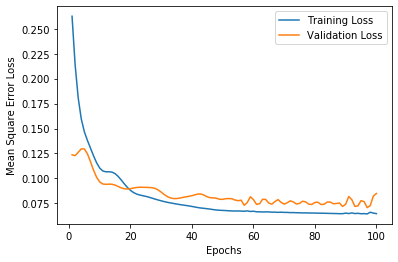

In [16]:
import matplotlib.pyplot as plt
df = pd.read_csv('SegLSTM.log',sep=',')
print(np.shape(df))
x = np.arange(1,EPOCHS+1,1)
yt = df['loss'].values
yv = df['val_loss'].values
plt.plot(x,yt,label='Training Loss')
plt.plot(x,yv,label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error Loss')
plt.savefig('TrainingLogLSTM.png')
plt.show()

### Computing loss on Test Data

In [17]:
from sklearn.metrics import mean_squared_error

testPredict = model.predict(x_test)
display(testPredict.shape)
display(y_test.shape)
testPredict=testPredict.reshape(testPredict.shape[0],testPredict.shape[1])
y_test=y_test.reshape(y_test.shape[0],y_test.shape[1])
display(testPredict.shape)
display(y_test.shape)
display(mean_squared_error(y_test,testPredict))

(659, 1024, 1)

(659, 1024, 1)

(659, 1024)

(659, 1024)

0.09307401503663452